In [4]:
#!git clone https://github.com/dpeschka/NumFluids.git
#!ls NumFluids

fatal: destination path 'NumFluids' already exists and is not an empty directory.
README.md  notebook


# Lecture 04: Finite Element Method 1D

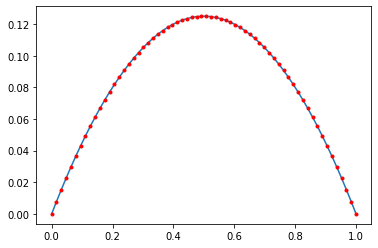

In [20]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def generate_elements1D(x):
    npo = x.size                            # number of points
    ne = npo-1                              # number of elements
    a = np.arange(0, npo-1).reshape((-1, 1))
    b = np.arange(1, npo).reshape((-1, 1))
    e1 = np.concatenate((a, b), axis=1)      # element specificiation
    return ne, npo, e1

def generate_transformation1D(k, e1, x):
    dx = x[e1[k, 1]]-x[e1[k, 0]]            # length of k-th interval
    Fdet = dx                             # determinant
    Finv = 1/dx                             # inverse transformation
    return Fdet, Finv

def local_mass1D(Fdet):
    return np.array(((1./3, 1./6), (1./6, 1./3)))*Fdet

def local_stiff1D(Fdet, Finv):
    G = np.array(Finv)
    sloc = np.zeros((2, 2))
    sloc[0, 0] = G.T.dot(G.dot(Fdet))
    sloc[0, 1] = - G.T.dot(G.dot(Fdet))
    sloc[1, 0] = sloc[0, 1]
    sloc[1, 1] = sloc[0, 0]
    return sloc

# FEM MATLAB sample code
N     = 64                           # 1D: number of points
nphi  =  2                           # P1: 2 local basis functions
x     = np.linspace(0, 1, N)         # array of points

ne, npo, e1 = generat_eelements1D(x) # generate mesh
localtoglobal1DP1 = e1               # could it be this simple? why?

# assemble matrices
ii = np.zeros((ne, nphi**2))         # sparse i-index
jj = np.zeros((ne, nphi**2))         # sparse j-index
aa = np.zeros((ne, nphi**2))         # entry of Galerkin matrix
bb = np.zeros((ne, nphi**2))         # entry in mass-matrix (to build rhs)

for k in np.arange(0, ne):
    Fdet, Finv = generate_transformation1D(k, e1, x)  # compute trafo
    
    # build local matrices (mass, stiffness, ...)
    sloc = local_stiff1D(Fdet, Finv)  # element stiffness matrix
    mloc = local_mass1D(Fdet)         # element mass matrix
    
    # compute i,j indices of the global matrix
    dofs = localtoglobal1DP1[k, :]
    ii[k, :] = [dofs[0], dofs[1], dofs[0], dofs[1]]  # local-to-global
    jj[k, :] = [dofs[0], dofs[0], dofs[1], dofs[1]]  # local-to-global
    
    # compute a(i,j) values of the global matrix      
    aa[k, :] = sloc.flatten(order="F")
    bb[k, :] = mloc.flatten(order="F")

A = sparse.csr_matrix((aa.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(N, N))
M = sparse.csr_matrix((bb.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(N, N))

# build rhs and take into account Dirichlet bcs, solve, plot
rhs = M.dot(np.ones(N))
u = np.zeros(N)
u[1:-1] = spsolve(A[1:-1, 1:-1], rhs[1:-1])

# plot solution
plt.figure()
plt.plot(x, u,x, x*(1-x)/2, 'r.')
plt.show()

# Lecture 04: Finite Element Method 2D

read mesh file: ../meshes/cheese


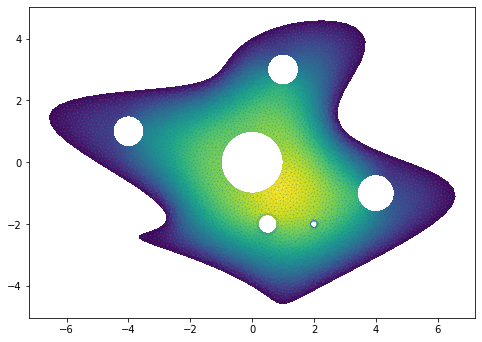

In [2]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from readtria import readtria

def generate_transformation2D(k, e2, x, y):
    dx1 = x[e2[k, 1]]-x[e2[k, 0]]
    dy1 = y[e2[k, 1]]-y[e2[k, 0]]

    dx2 = x[e2[k, 2]]-x[e2[k, 0]]
    dy2 = y[e2[k, 2]]-y[e2[k, 0]]

    # determinant on each triangle
    Fdet = dx1*dy2 - dx2*dy1

    # transformation Jacobian on each triangle
    Finv = np.zeros((2, 2))
    Finv[0, 0] =  dy2 / Fdet
    Finv[0, 1] = -dx2 / Fdet
    Finv[1, 0] = -dy1 / Fdet
    Finv[1, 1] =  dx1 / Fdet

    return Fdet, Finv


def local_stiff2D(Fdet, Finv):
    gradphi = np.array([[-1, -1], [1, 0], [0, 1]])
    dphi    = gradphi.dot(Finv)
    S = 1/2*(dphi[:, 0].reshape(-1, 1).dot(dphi[:, 0].reshape(1, -1)) +
             dphi[:, 1].reshape(-1, 1).dot(dphi[:, 1].reshape(1, -1)))*Fdet
    return S

def local_mass2D(Fdet):
    return Fdet*np.array([[1, 1/2, 1/2], [1/2, 1, 1/2], [1/2, 1/2, 1]])/12

# FEM Python sample code
x, y, npo, ne, e2, idp, ide = readtria('../meshes/cheese')  # read mesh from file
localtoglobal2DP1           = e2                  # could it be this simple? why?

# select points without Dirichlet bc
it = np.logical_not(idp == 1)
nphi = 3

# build matrices
ii = np.zeros((ne, nphi**2))  # sparse i-index
jj = np.zeros((ne, nphi**2))  # sparse j-index
aa = np.zeros((ne, nphi**2))  # entry of Galerkin matrix
bb = np.zeros((ne, nphi**2))  # entry in mass-matrix (to build rhs)

for k in np.arange(0, ne):
    Fdet, Finv = generate_transformation2D(k, e2, x, y)  # compute trafo
    #
    # build local matrices (mass, stiffness, ...)
    sloc = local_stiff2D(Fdet, Finv)  # element stiffness matrix
    mloc = local_mass2D(Fdet)       # element mass matrix
    #
    # compute i,j indices of the global matrix
    dofs = localtoglobal2DP1[k, :]
    ii[k, :] = dofs[[0, 1, 2, 0, 1, 2, 0, 1, 2]]  # local-to-global
    jj[k, :] = dofs[[0, 0, 0, 1, 1, 1, 2, 2, 2]]  # local-to-global
    #
    # compute a(i,j) values of the global matrix
    aa[k, :] = sloc.flatten(order="F")
    bb[k, :] = mloc.flatten(order="F")

# create sparse matrices
A = sparse.csr_matrix((aa.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(npo, npo))
M = sparse.csr_matrix((bb.flatten(order="F"), (ii.flatten(
    order="F"), jj.flatten(order="F"))), shape=(npo, npo))

# build rhs and take into account Dirichlet bcs, solve, plot
rhs = M*np.ones(npo)
u = np.zeros(npo)
u[it] = spsolve(A[np.ix_(it, it)], rhs[it])

# plotting
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

#fig = plt.figure()

#ax = fig.gca(projection='3d')
#ax.plot_trisurf(x, y, u, triangles=e2)
#plt.show()

plt.triplot(x,y,triangles=e2,linewidth=0.1)
plt.tripcolor(x,y,u,triangles=e2)